# HOMEWORK 1

**Introduction**

The scope of this homework is to discover the link between the *round trip time*
and the distance which a server is allocated.
At first a set of libraries are imported that will be useful in the deployment of the code.
In particular the *csv* library is needed to upload the csv file containing a list of servers.
Since the Colab VM has been used for the development of this code, the servers are not reported in a specific order, but according to the paramenter *distanza*
defined in the code, there will be a sorting based on such distances.

In [1]:
!pip install --pre scapy[basic]
!pip install pythonping
from pythonping import ping
import csv
import numpy as np
import pandas as pd
import urllib.request
import json
import socket
from geopy import distance
import matplotlib as mpl
import matplotlib.pyplot as plt
from scapy.all import *

     |████████████████████████████████| 1.1 MB 21.0 MB/s 
  Created wheel for scapy: filename=scapy-2.4.5-py2.py3-none-any.whl size=1261555 sha256=6ab4d33e8874450bde135b7e348535c042116d1bf8c7647fc2d32416976ad425
  Stored in directory: /root/.cache/pip/wheels/b9/6e/c0/0157e466a5e02d3ff28fc7587dff329b4a967a23b3f9b11385
Successfully built scapy



The following lines of code are used to identify the position of the server, this VM is working with. 

In [2]:
ip = urllib.request.urlopen('https://api.ipify.org').read().decode('UTF-8')
ip_info = json.loads(urllib.request.urlopen('http://ip-api.com/json/' + ip).read())

print('External IP: ', ip)
print('Organization: ', ip_info["org"])
print('Location: ', ip_info["city"], ',', ip_info["country"])


External IP:  34.86.208.157
Organization:  Google Cloud (us-east4)
Location:  Washington , United States


# First assignment

Now that all the libraries have been downloaded, we can procede with the assignment.
The .csv file, is a file composed by two columns, the first one is related to the url of the servers while the second is a string that indicates its position as a country (f.i. Italy, France ecc...)
The position of the columns is irrelevant, in fact once understood the the delimiter between each column is a ' ; ' with the line of code

* url_servers = servers['URL server ']  

the column that identifies the url is selected


In [3]:


#reading the csv file containing all the target servers
servers = pd.read_csv("serverslist.csv", delimiter= ';')
url_servers = servers['URL server ']

#the dictionary RTT will be a dictionary formed by key = url
#while values = distance + RTT
#if in a future will be needed to retrieve the distance and RTT related to a 
#specific target, this can be easily done with the dictionary 'RTT'
RTT = {}

#the dictionary dist_rtt insted will be used while plotting data
#[the key = distance] while [the value = RTT]
#in this way the plotting of RTT vs DISTANCE has been possible
dist_rtt = {}

#creating an auxiliary list to store all the values found for the rtt per 
#measurement used to obtained the avg rtt
rtt = []

#iterating for each row containing only the url server
for row in url_servers:

    target = row   
    
    #in here I am getting info about the target url
    ip_info_target = json.loads(urllib.request.urlopen('http://ip-api.com/json/' + socket.gethostbyname(target)).read())
    
    #creating packet ICMP specifying its type
    packet = IP(dst=target)/ ICMP(type = 'echo-request') 
     
    for x in range(50):
      
      ans, unans = sr(packet, verbose = False, timeout = 2)

      #with this if statement, I am checking whether the targeted server 
      #is reachable, if not it will continue with the next one in the list of
      #servers

      if(len(ans)>0):
     
        rtt.append((ans[0][1].time - ans[0][0].sent_time)*1000)
        
        #once all the measurement of the rtt are done, and average one is 
        #calculated with the following line of code
        avg_rtt = sum(rtt)/len(rtt)     
        #in this line I am calculating the distance between the targeted server
        # and my server's position in kilometers
        distanza = distance.distance((ip_info['lat'],ip_info['lon']), (ip_info_target['lat'],ip_info_target['lon'])).km  

        #and finally I am updating my datastructures
        dist_rtt[distanza] = avg_rtt
        RTT[target] =distanza,avg_rtt
        
      else:       
        continue      
        
    #to the user is printed a set of informations, representing the RTT between 
    #location and the distance between his location and the targeted server

    print('******************************************************************************************************************')
    print()
    print('The RTT for the distance between:', ip_info["org"],'and ',ip_info_target["country"], 'is','%.2f' % avg_rtt,'ms')
    print('The distance between the location of this VM (',ip_info['country'],') and the server located in',ip_info_target['country'], 'is : ','%.2f' % distanza ,'km')
    print()
 


******************************************************************************************************************

The RTT for the distance between: Google Cloud (us-east4) and  Australia is 196.40 ms
The distance between the location of this VM ( United States ) and the server located in Australia is :  15943.48 km

******************************************************************************************************************

The RTT for the distance between: Google Cloud (us-east4) and  Austria is 149.00 ms
The distance between the location of this VM ( United States ) and the server located in Austria is :  7137.42 km

******************************************************************************************************************

The RTT for the distance between: Google Cloud (us-east4) and  Belgium is 127.03 ms
The distance between the location of this VM ( United States ) and the server located in Belgium is :  6287.15 km

**************************************************

Now that all the measurement have been done, it is possible to procede with the plots. 
Using the dictionary "*dist_rtt*" sorted, two lists are retrieved and used to obtain a line the will represent the variation of the RTT over the distance.


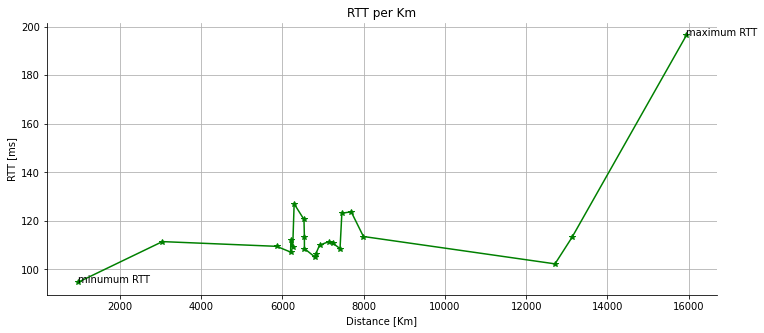

In [4]:
#now that we have obtained our data structure in which are present both RTT
#and distances we can procede plotting our results
#the following list will be used in order to store the distances and RTT values 
x_axis = []
y_axis = []

#with the following for cycle the dictionary formed by distances and avg values
#is sorted from the minimum distance to the largest one
for x in sorted(dist_rtt):
  x_axis.append(x)
  y_axis.append(dist_rtt[x])

#plotting the RTT / Km with some personalizations

fig = plt.figure(figsize=(12,5));
plt.title("RTT per Km");
plt.plot(x_axis,y_axis,'-*',color='green');
plt.gca().spines['top'].set_visible(False);
plt.gca().spines['right'].set_visible(False);
plt.annotate('minumum RTT',(x_axis[0],y_axis[0]));
plt.annotate('maximum RTT',(x_axis[-1],y_axis[-1]));
plt.xlabel("Distance [Km]");
plt.ylabel("RTT [ms]");
plt.grid(visible=True);
plt.show()




#Second assignment

Once obtained the plot that relates the experimental values founded for the RTT,it is considered the formula: 
           
               RTT = 2*(L/C + d/v) + n             (1)
And a set of RTTs have been founded considering it.

At first the theoretical values of RTT founded with (1) will be plotted with the use of *polyfit* function.
If we consider the main approximation of the above formula,this will lead us to a straight line, that is quite different from the one obtained with the active measurements.

Once understood that the RTT depends on many factors, that sometimes cannot be neglected, the same function polyfit will be used to obtain a *fitted line* that will describe the behaviour of the RTT founded with measurements.

For this reason it will be presented in the following:


1.   Confrontation between Experimental and Theoretical RTT
      (The one found with (1))
2.   Confrontation between Experimental and Fitted RTT
      (found with the use of *polyfit* on experimental results)



# Confrontation between Experimental and Theoretical RTT

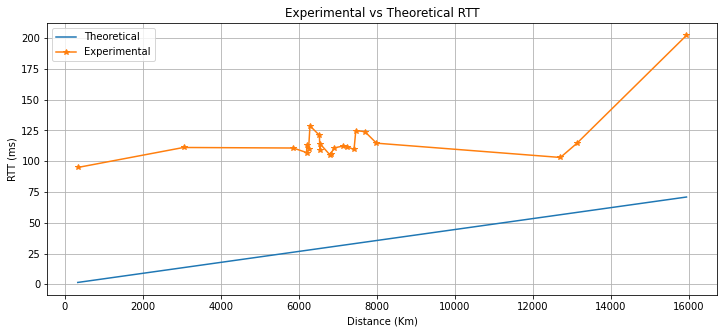

In [ ]:
#here is defined a list for storing the theoretical values for the RTT 
#it is also defined the variable 'speed_v' in [m/s]
rtt_fitted = []
speed_v = 299792458

for x in x_axis:
  rtt_fitted.append(x*4000/(3*speed_v)*1000)
#using the polyfit function to determine the fitted line that will give us 
# a representation of the RTT
fig = plt.figure(figsize=(12,5));
p=np.polyfit(x_axis,rtt_fitted,1)
y_fitted = np.polyval(p,x_axis);
plt.plot(x_axis,y_fitted);
plt.plot(x_axis,y_axis,'-*');
plt.xlabel("Distance [Km]");
plt.ylabel("RTT [ms]");
plt.title("Experimental vs Theoretical RTT");
plt.grid(visible=True);
plt.legend(("Theoretical","Experimental"));

# Confrontation between Experimental and Fitted RTT

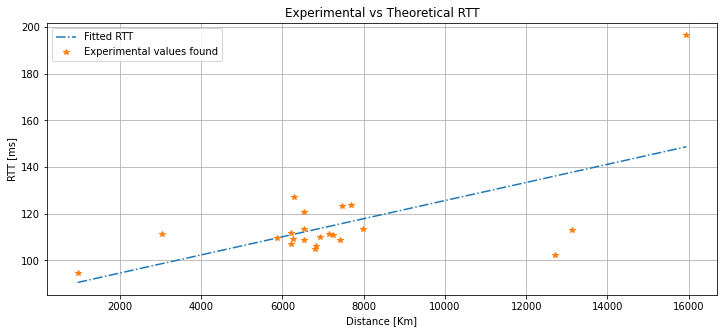

In [5]:
fig = plt.figure(figsize=(12,5));
p=np.polyfit(x_axis,y_axis,1)
y_fitted = np.polyval(p,x_axis);
plt.plot(x_axis,y_fitted,'-.');
plt.plot(x_axis,y_axis,'*');
plt.xlabel("Distance [Km]");
plt.ylabel("RTT [ms]");
plt.title("Experimental vs Theoretical RTT");
plt.grid(visible=True);
plt.legend(("Fitted RTT","Experimental values found"));

# Conclusions
**Comparison between theoretical and experimental case**

The RTT formula above mentioned represents a generalization of a statistic that depends on many factors. For this reason the approximation done cannot be applied in the real case.
First of all we can see a huge difference in terms of RTTs:
in the experimental case, the avg RTT is around 148 ms, quite different 
with respect to the theoretical ones (50 ms).
While the theoretical case has a straight increasing behaviour, the experimental one presents some irregolarities: f.i., it is not always true that increasing the distance between two servers, we are increasing also the ping time. In a lot of trials done, usually the higher RTT was around the distance 8000-10000 Km.
This, is to demostrate that in calculating statistics of a network, it is not possible to base our analysis on generalized and approximated models. In here, the bandwidth of the channel through it was sent the ICMP request and some noise contributes, have intensely influenced the RTT values giving results different from the expected ones.

Moreover it is shown in the following that using higher order polynomial,better fits the behaviour of the RTT/Km.





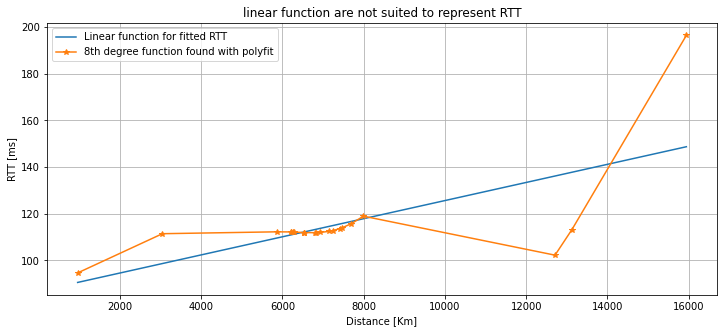

In [6]:
#Here I am using polyfit function to show that a linear
#function is not the best choice for representing RTT behaviour

p=np.polyfit(x_axis,y_axis,1)
y_fitted = np.polyval(p,x_axis)
p1=np.polyfit(x_axis,y_axis,8)
y_fitted1 = np.polyval(p1,x_axis)
fig = plt.figure(figsize=(12,5));
plt.plot(x_axis,y_fitted)
plt.plot(x_axis,y_fitted1,'-*')
plt.xlabel("Distance [Km]");
plt.ylabel("RTT [ms]");
plt.grid(visible=True)
plt.legend(("Linear function for fitted RTT","8th degree function found with polyfit"))
plt.title("linear function are not suited to represent RTT");

As it is shown in the picture above, higher order polynomial better interpolates the particular behaviour of the RTT per Km, leading to a result more similar to the experimental one.